<img src="images/body-part-regression-title.png" width=1000/>

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("../")
from utils import * 

# define paths 
input_path = "COVID-19-AR/nifti_files/"
output_path = "COVID-19-AR/output_files/"
cropped_path = "COVID-19-AR/cropped_nifti_files/"
cropped_json_path = "COVID-19-AR/cropped_output_files/"

# Preprocess CT scans in COVID-19 dataset

## 1. Download Data 
<br>
<font size="3.8" style="line-height:160%">
Download COVID-19 CT dataset from <a href="https://zenodo.org/record/5596270#.YXaqJ9lBxQI">Zenodo</a>. <br><br>
The dataset source is the COVID-19-AR data from 
<a href="https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226443">the Cancer Image Archive</a>.
</font>

------------------------------------------------------

   
<img src="images/tcia-screenshot.png" width=1000/>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## 2. Analyze Data 

In [2]:
plot_volumes_interactive(input_path, start_index=36) 

interactive(children=(BoundedFloatText(value=36.0, description='File:', max=190.0, step=1.0), Output()), _dom_…

<br> 
<br> 
<br> 
<br> 
<br>
<br>
<br>

--------------------------------------------


<img src="images/problems-with-covid19-dataset.png" width=1000/>
<br>
<br>

## 3. Define preprocessing steps 
<font size="3.8" style="line-height:200%">
    1. <b>Remove invalid CT scans</b> <br>
- filter CT scans, with wrong axis ordering <br>
- filter corrupted CT scans, where no human body is visible <br>
- filter CT scans with less than 20 slices <br>
    2. <b> Remove CT scans, where the lungs are not fully visible </b><br>
    3. <b> Crop lungs out of CT scans if more body regions are visible </b>
</font><br><br>
<font size="5" style="line-height:200%">&rarr; <b>Goal: CT dataset where in all scans the lungs were examined </b></font>

<br><br><br><br><br><br><br><br><br><br><br><br>



## 4. Use Body Part Regression for Preprocessing

<br>
<font size="4" style="line-height:160%">
<a href="https://github.com/MIC-DKFZ/BodyPartRegression">Body Part Regression Python Package</a>
</font>




<img src="images/body-part-regression-explanation.png" width=1000/>
<br><br><br><br><br><br><br><br><br><br><br><br>

## 5. Create body part metadata file for each CT image 
<img src="images/Main-body-part-regression-function.png" width=800/>


In [3]:
from bpreg.scripts.bpreg_inference import bpreg_inference
# bpreg_inference(input_path, output_path, plot=True)

<br><br><br><br><br><br>

## 6. Analyze body part meta data files

In [4]:
plot_scores_interactive(output_path, input_path, start_index=166)

interactive(children=(BoundedFloatText(value=166.0, description='File:', max=190.0, min=166.0, step=1.0), Outp…

191it [00:00, 470.90it/s]


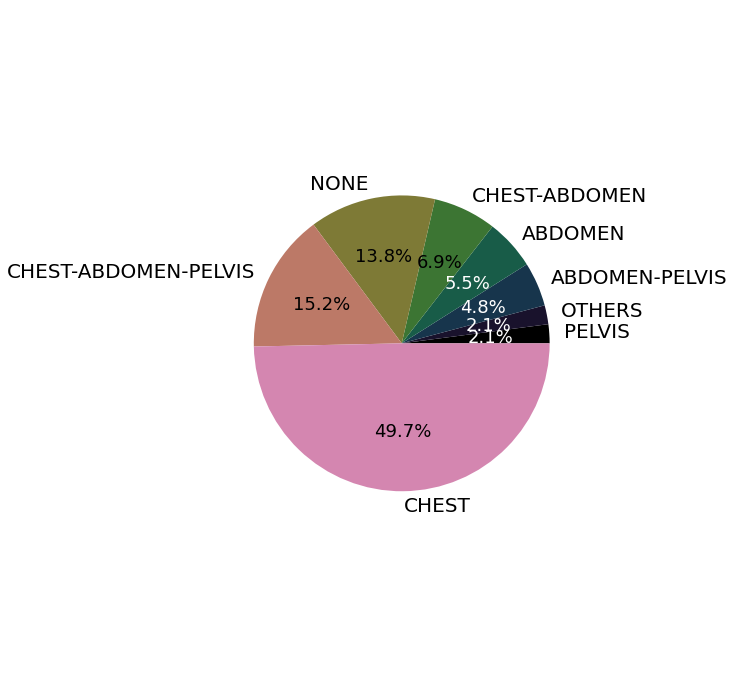

In [5]:
df = create_meta_data_table(output_path)

# Filter CT scans with less than 20 slices 
df = df[df.z > 20]

plot_dicomexamined_distribution(df, 
                                others_percentage_upper_bound=0.015)


## 7. Remove invalid CT scans
<br>
<font size="3.8" style="line-height:140%">
    Filter CT scans, were the predicted body part is <b>NONE</b>
</font>

In [6]:
# Filter corrupted CT scans 
df_cleaned = df[df['BODY PART'] != 'NONE']
print(f"Dataset size after removing {len(df) - len(df_cleaned)} corrupted CT scans: {len(df_cleaned)}") 

Dataset size after removing 20 corrupted CT scans: 125


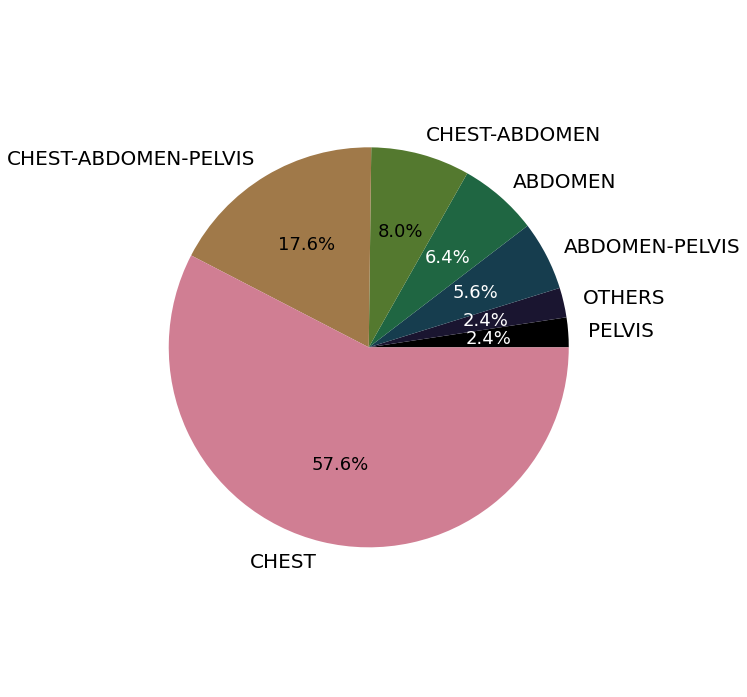

In [7]:
plot_dicomexamined_distribution(df_cleaned, 
                                others_percentage_upper_bound=0.02)

## 8. Filter chest CT scans

In [8]:
# Removing CT scans where the chest is not examined
df_cleaned = df_cleaned[df_cleaned['BODY PART'].str.contains('CHEST')]
print(f"Dataset after removing CT scans, where the CHEST is not visible:  {len(df_cleaned)}") 

Dataset after removing CT scans, where the CHEST is not visible:  107


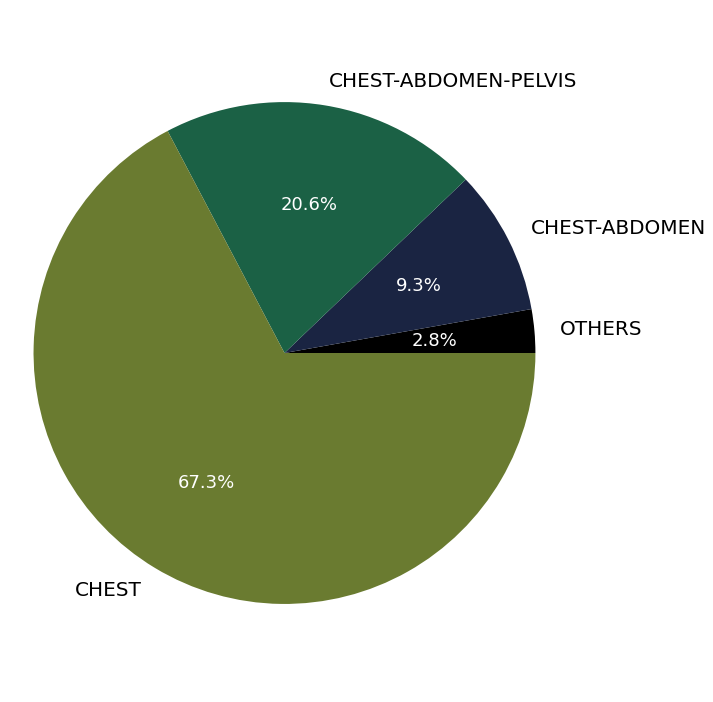

In [9]:
plot_dicomexamined_distribution(df_cleaned, 
                                others_percentage_upper_bound=0.02)

<br><br><br><br><br><br>
## 9. Crop chest region out of CT scan

<img src="images/Landmarks-for-cropping.png" width=1000/>

In [10]:
import pandas as pd
json_filepaths = [output_path + f for f in os.listdir(output_path) if f.endswith(".json")]
x = load_json(json_filepaths[0])
lookuptable = pd.DataFrame(x["look-up table"]).T
lookuptable.sort_values(by="mean")[["mean"]]

,mean
pelvis_start,0.000
femur_end,13.616
L5,25.532
pelvis_end,28.824
L4,29.414
L3,33.817
kidney,37.597
L2,37.763
L1,41.478
lung_start,44.143


In [11]:
nifti_filepaths = [input_path + f.replace(".json", ".nii.gz") for f in df_cleaned.FILE]

# crop and save ct images to chest region 
# crop_ct_images(nifti_filepaths, output_path,  cropped_path, save=True)

# create body part meta data for cropped images
# bpreg_inference(cropped_path, cropped_json_path, plot=True, gpu_available=False)

<br><br><br><br><br><br>
## 10. Analyze preprocessed dataset 

In [14]:
plot_volumes_interactive(cropped_path)

interactive(children=(BoundedFloatText(value=0.0, description='File:', max=108.0, step=1.0), Output()), _dom_c…

<br><br><br><br><br><br>
# Thank you for your attention!
<br>
<font size="4.5" style="line-height:140%">
You find the notebook at: <a>www.github.com/MIC-DKFZ/BodyPartRegression/docs/notebooks</a><br>
Please feel free to reach out if you have questions.
 </font>
<br>
<br>
<img src="images/emoji-hug.png" width=300/>
<br><br><br><br><br><br><br><br><br><br><br><br>